# Import Library

In [ ]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,plot_confusion_matrix


# Download and Read Data

## Download data

We use Linux command line to download and unzip/untar the downloaded dataset.

In [ ]:
# Download the data
!wget --no-directories "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
!gunzip aclImdb_v1.tar.gz
!tar  -xf aclImdb_v1.tar

--2021-08-12 20:45:58--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  28.7MB/s    in 2.8s    

2021-08-12 20:46:01 (28.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
%ls ./aclImdb/ 

imdbEr.txt  imdb.vocab  README  test/  train/


## Read Data into DataFrame

We walk through all the train folders and test folders where each review is saved as a text file with review score in the filename. We load the training and testing data from the file system to dataframe. Any review with score over five is labeled with "positive" and any review with score below or equal to 5 is labeled with "negative".

In [ ]:
train_folders = ["./aclImdb/train/pos", "./aclImdb/train/neg"]
test_folders = ["./aclImdb/test/pos", "./aclImdb/test/neg"]
import os

def process_data(folders):
    data_dict = []
    label_list = []
    for folder in folders:
        for root, dirs, files in os.walk(folder, topdown=False):
            for name in files:
                filename = os.path.join(root, name)
                content = ""
                with open(filename, "r", encoding="ISO-8859-1") as fd:
                    for line in fd.readlines():
                        content += line
                name_score, suffix = name.split(".")
                name, score = name_score.split("_")
                data_dict.append({"filename": filename, "content": content})
                if int(score) > 5:
                    label_list.append("positive")
                else:
                    label_list.append("negative")
    return data_dict, label_list

In [ ]:
train_data, train_label = process_data(train_folders)

In [ ]:
test_data, test_label = process_data(test_folders)

In [ ]:
train_DF = pd.DataFrame({"label": train_label, 
                   "content": [i["content"] for i in train_data],
                   "filename": [i["filename"] for i in train_data]}
                 )

In [ ]:
test_DF = pd.DataFrame({"label": test_label, 
                   "content": [i["content"] for i in test_data],
                   "filename": [i["filename"] for i in test_data]}
                 )

In [ ]:
train_DF.head()

label  ...                         filename
0  positive  ...   ./aclImdb/train/pos/3009_8.txt
1  positive  ...   ./aclImdb/train/pos/9901_8.txt
2  positive  ...   ./aclImdb/train/pos/3949_8.txt
3  positive  ...  ./aclImdb/train/pos/2331_10.txt
4  positive  ...   ./aclImdb/train/pos/5474_9.txt

[5 rows x 3 columns]

In [ ]:
list(train_DF["content"][0:1])

['A film that is so much a 30\'s Warners film in an era when each studio had a particular look and style to their output, unlike today where simply getting audiences is the object.<br /><br />Curitz was one of the quintessential Warners house directors working with tight economy and great efficiency whilst creating quality, working methods that were very much the requirements of a director at Warners, a studio that was one of the "big five" majors in this era producing quality films for their large chains of theatres.<br /><br />Even though we have a setting of the upper classes on Long Island there is the generic Warners style embedded here with a narrative that could have been "torn from the headlines". Another example is the when the photographers comment on the girls legs early in the film and she comments that "They\'re not the trophies" gives the film a more working mans, down to earth feel, for these were the audiences that Warners were targeting in the great depression. (ironic

# Exploratory Data Analysis

## Check data size and distribution

Check the data size and also the size of each class for training data. In case the data is imbalanced, we need to either resample the data and/or use algorithms that can work with imbalanced data. 

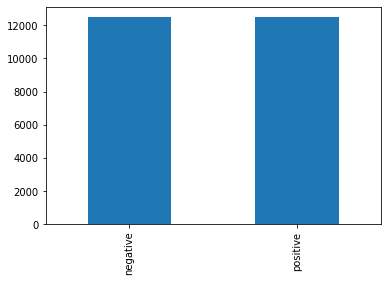

In [ ]:
train_DF.label.value_counts().plot(kind="bar")

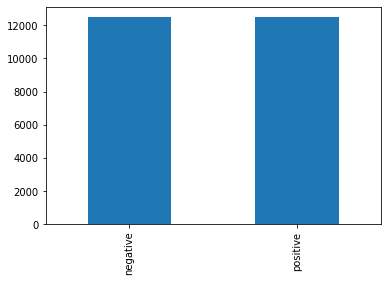

In [ ]:
test_DF.label.value_counts().plot(kind="bar")

## Text Preprocessing

The basic preprocessing here include 
1. replacing special characters with space, which helps with tokenization
2. tokenize the text to list of words
3. remove the stop words
4. get the lemma of the non-stop words

In the last, we save the processed result into a different field, namely "processed_content", to the dataframes.

In [ ]:
import re
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|(\_)")
def tokenizeandstopwords(text):
    text = text.lower()
    text = re.sub(r"[^a-z ]+", " ", text)
    text = REPLACE_WITH_SPACE.sub(" ", text)
    tokens = nltk.word_tokenize(text)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    meaningful_words = [wnl.lemmatize(w) for w in token_words if not w in set(stopwords).union(set(["br"]))]
    joined_words = ( " ".join(meaningful_words))
    return joined_words

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
train_DF['processed_content'] = train_DF['content'].apply(tokenizeandstopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
test_DF['processed_content'] = test_DF['content'].apply(tokenizeandstopwords)

In [ ]:
train_DF['processed_content'] = train_DF['content'].apply(tokenizeandstopwords)

## Uni-gram Word Cloud

Here we use word cloud to visualize the unigram.

In [ ]:
positive = train_DF[train_DF["label"] == "positive"]
negative = train_DF[train_DF["label"] == "negative"]

In [ ]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

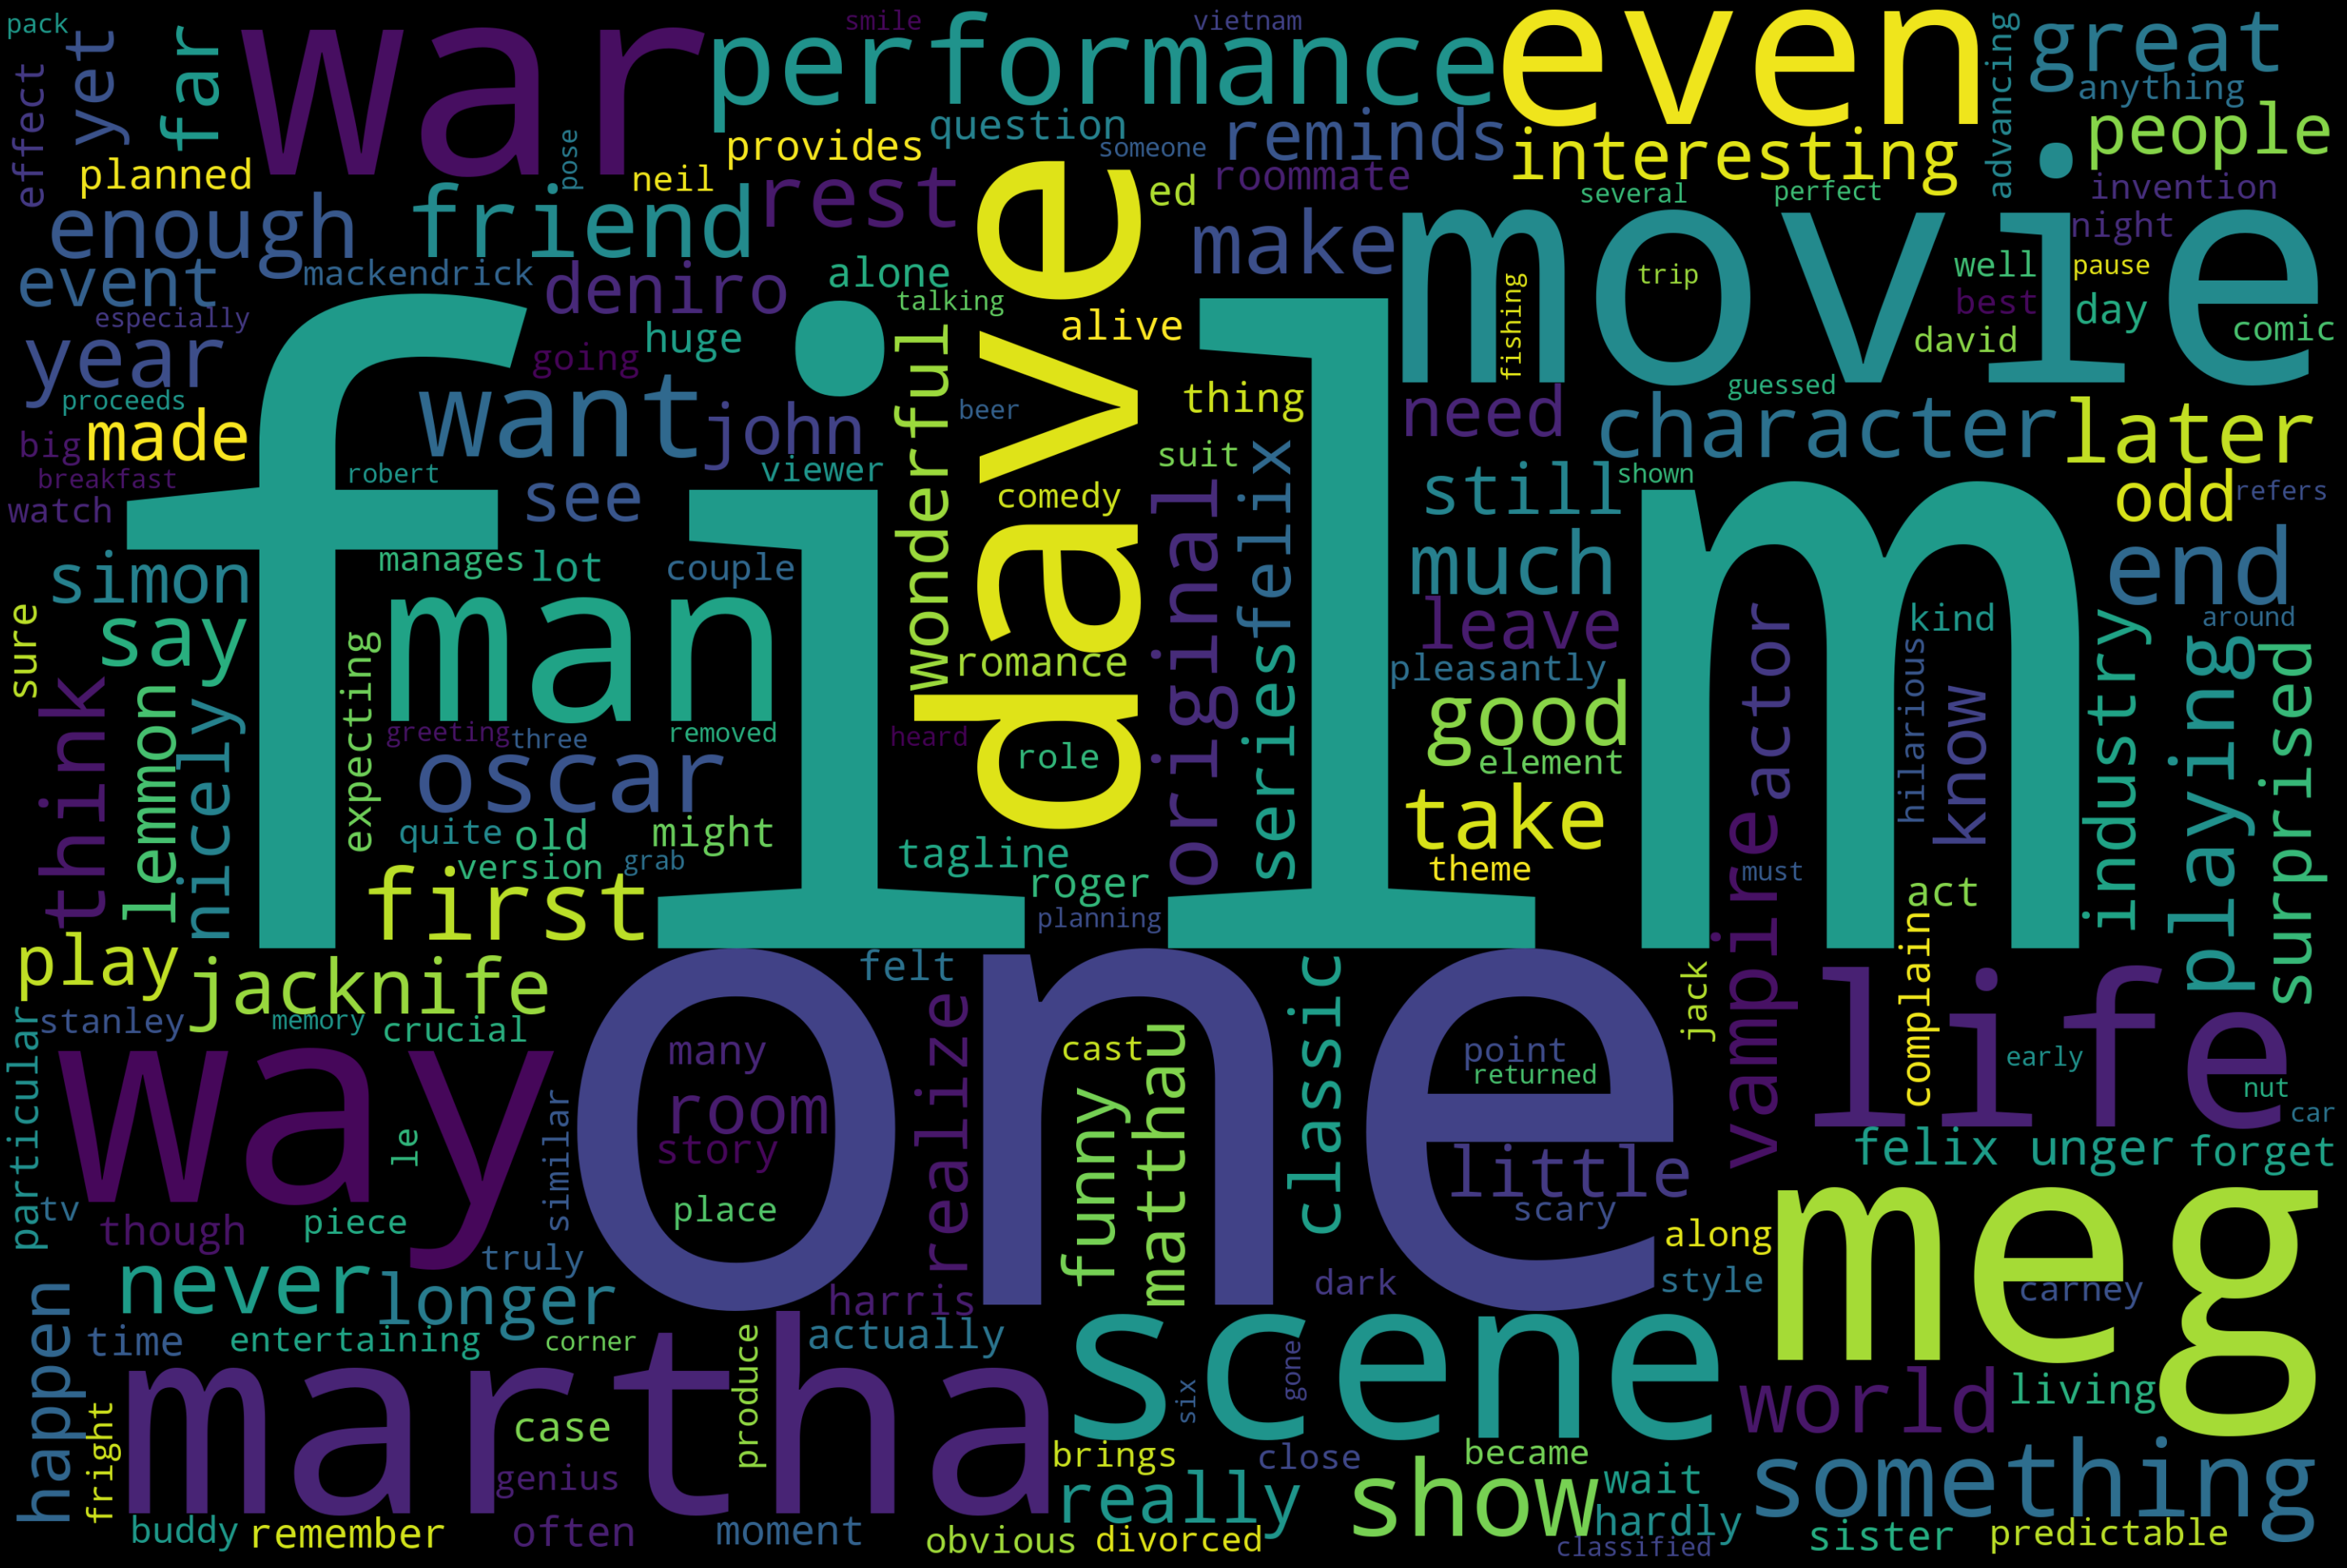

In [ ]:
generate_word_cloud(positive.processed_content.values)

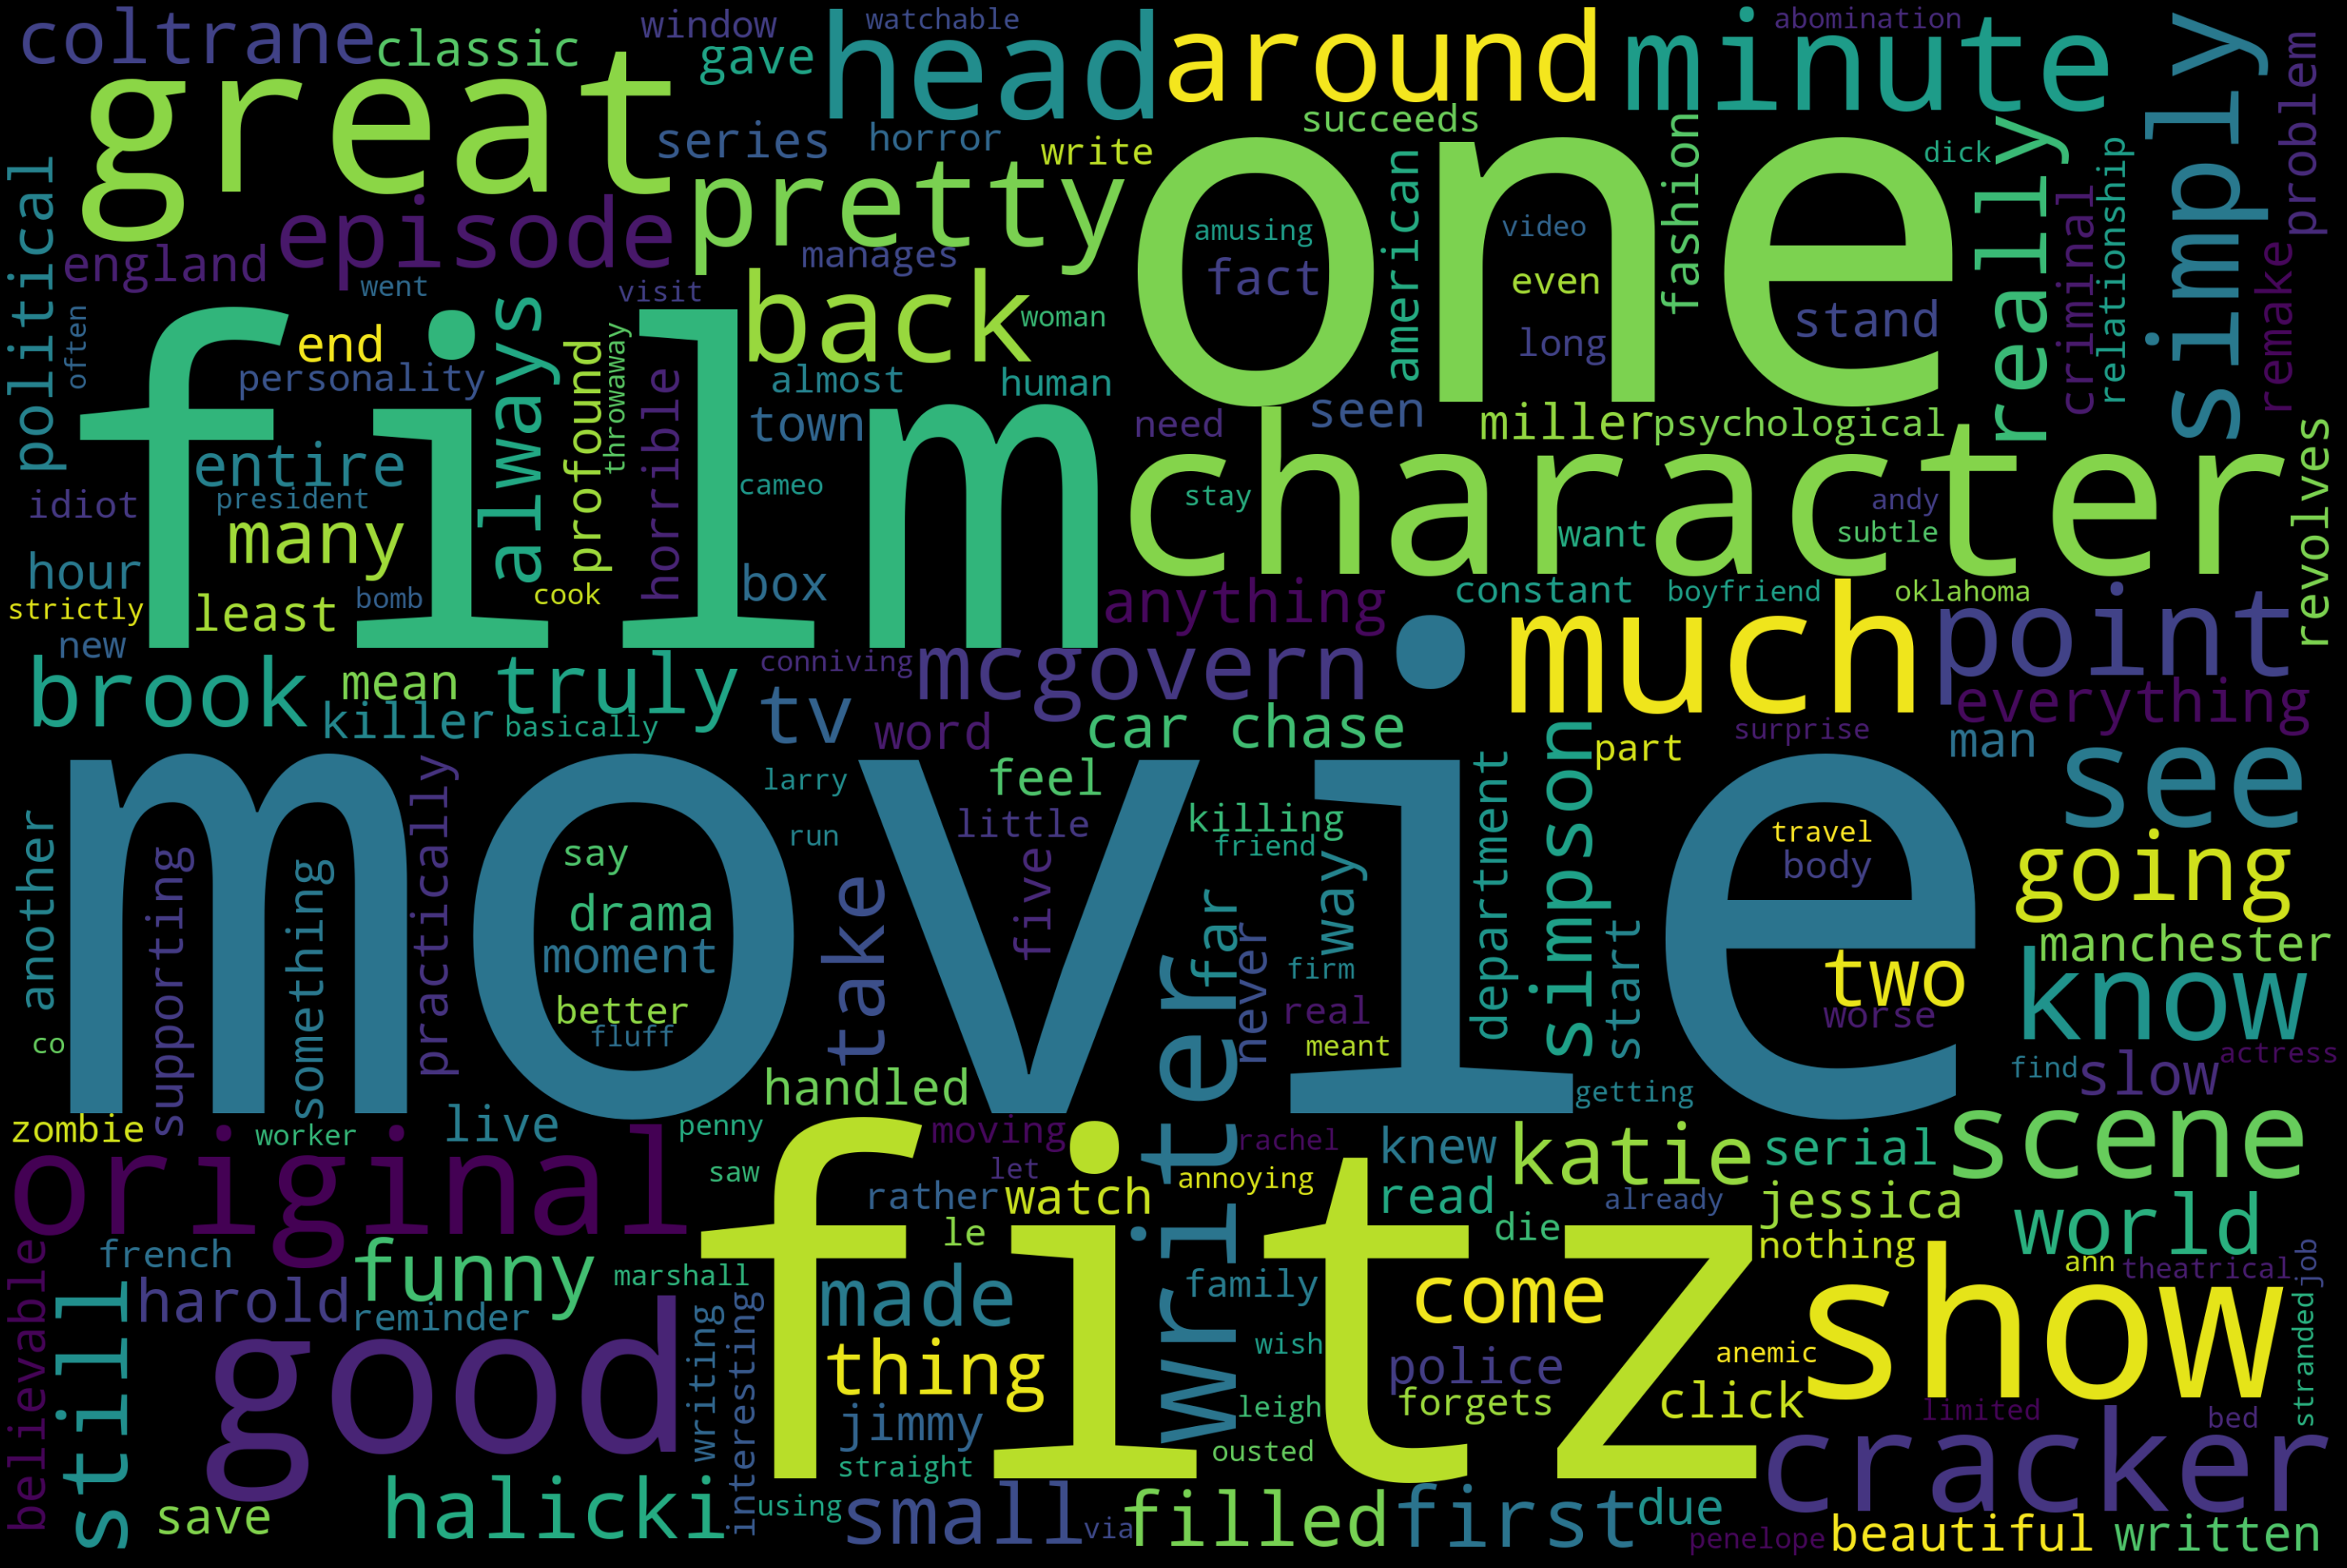

In [ ]:
generate_word_cloud(negative.processed_content.values)

In [ ]:
Top-20 Most Fre

## Top 20 Most Frequency Bigram

Text(0.5, 0, '# of Occurances')

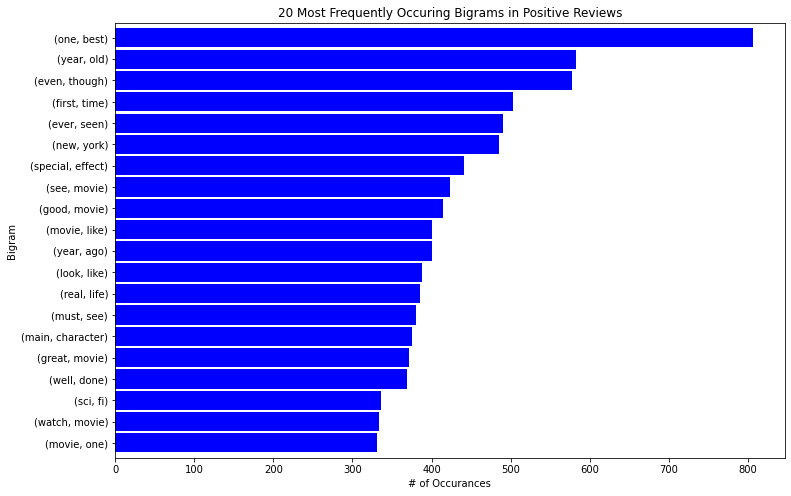

In [ ]:
import itertools
positive_words = list(itertools.chain(*positive["processed_content"].apply(lambda x: x.split()).tolist()))
positive_bigrams_series = (pd.Series(nltk.ngrams(positive_words, 2)).value_counts())[:20]
positive_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams in Positive Reviews')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

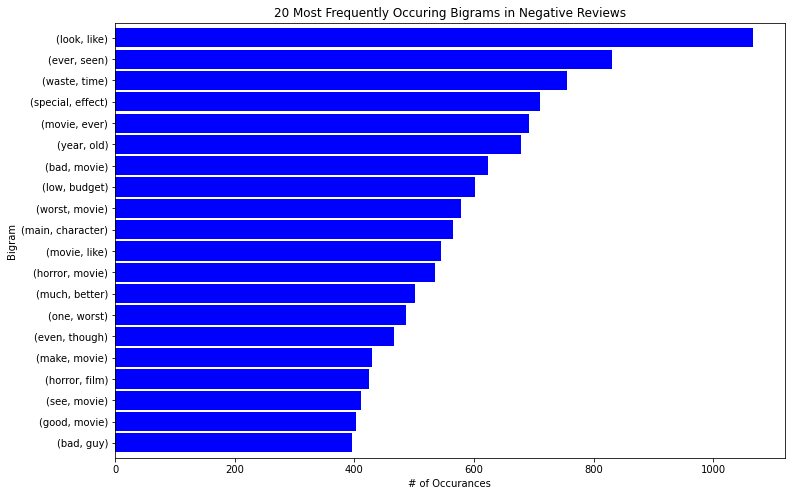

In [ ]:
negative_words = list(itertools.chain(*negative["processed_content"].apply(lambda x: x.split()).tolist()))
negative_bigrams_series = (pd.Series(nltk.ngrams(negative_words, 2)).value_counts())[:20]
negative_bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Bigrams in Negative Reviews')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

## Top 20 Most Frequent Trigram

Text(0.5, 0, '# of Occurances')

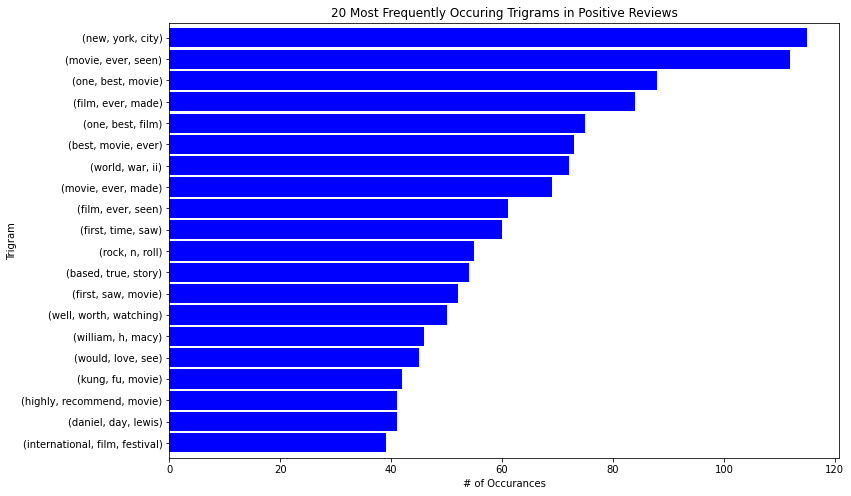

In [ ]:
import itertools
positive_trigrams_series = (pd.Series(nltk.ngrams(positive_words, 3)).value_counts())[:20]
positive_trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams in Positive Reviews')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

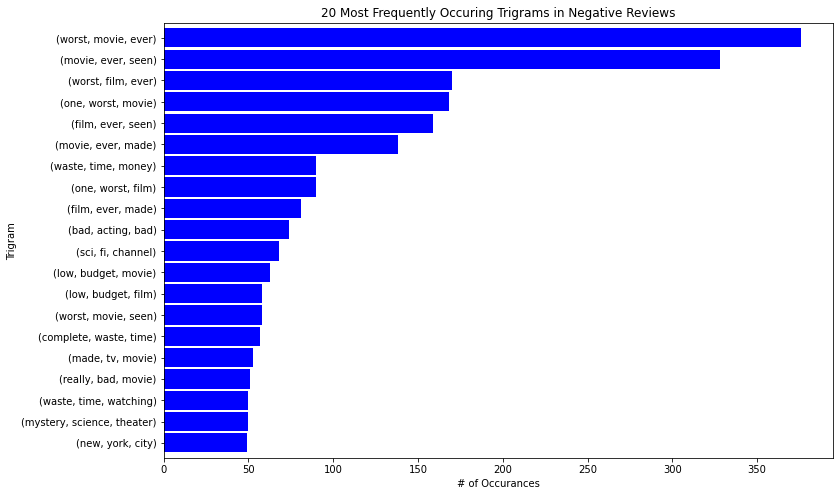

In [ ]:
negative_trigrams_series = (pd.Series(nltk.ngrams(negative_words, 3)).value_counts())[:20]
negative_trigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('20 Most Frequently Occuring Trigrams in Negative Reviews')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

# N-gram TF-IDF Logistic Regression Model

## Base Model and Feature Exploration

### Build a model with Pipeline

In [ ]:
pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
model = pipe.fit(train_DF['processed_content'], train_DF['label'])


### Inspect Features

In [ ]:
feature_names = model.named_steps['vect'].get_feature_names()
feature_names[0:10]

['aa',
 'aaa',
 'aaaaaaah',
 'aaaaah',
 'aaaaatch',
 'aaaahhhhhhh',
 'aaaand',
 'aaaarrgh',
 'aaah',
 'aaargh']

Get the count vectors for each sentence by using the vocabulary only in the sentence list

In [ ]:
sentence_list = ["I love cartoon movies, but I hate action movies. ",
                 "I love action movies, but I hate cartoon movies",
                "I love basketball, but I love table tennis more"]

In [ ]:
word_set = set()
for sentence in sentence_list:
  for word in sentence.split():
    if word in feature_names:
      word_set.add(word)
word_set = list(sorted(word_set))

for i in range(len(sentence_list)):
  result.append([0]*len(word_set))
for i in range(len(sentence_list)):
   words = sentence_list[i].split()
   for word in word_set:
     if word in words:
       result[i][word_set.index(word)] +=1
print(word_set)
print(result)

    

['action', 'cartoon', 'hate', 'love', 'more', 'table', 'tennis']
[[1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 0, 0, 0], [0, 0, 0, 1, 1, 1, 1]]


Inspect the counts of word "love" in the counting vectors by using the trained  count vectorize, which uses all the vocabulary from the training data

In [ ]:
sentence_list_count = model.named_steps['vect'].transform(sentence_list).toarray()
sentence_list_count[:, feature_names.index("love")]

array([1, 1, 2])

### Inspect the Output of TF-IDF

In [ ]:
tf_idf = model.named_steps['tfidf'].transform(sentence_list_count)

In [ ]:
print(tf_idf)

  (0, 34223)	0.33724370177778445
  (0, 25635)	0.5639385905805436
  (0, 8668)	0.6302418880961854
  (0, 475)	0.41356391785817337
  (1, 34223)	0.33724370177778445
  (1, 25635)	0.5639385905805436
  (1, 8668)	0.6302418880961854
  (1, 475)	0.41356391785817337
  (2, 57625)	0.526075858515381
  (2, 56868)	0.3726285091145331
  (2, 38083)	0.5224501498536809
  (2, 34223)	0.339415845492055
  (2, 4549)	0.44298409681292733


In [ ]:
pd.DataFrame(model.named_steps['tfidf'].idf_).describe()

0
count  65493.000000
mean       9.379146
std        1.382608
min        1.431746
25%        8.824086
50%       10.028059
75%       10.433524
max       10.433524

In [ ]:
model.named_steps['tfidf'].idf_[feature_names.index("love")]

2.6754040617502888

In [ ]:
tf_idf.toarray()[:, feature_names.index("love")]

array([0.3372437 , 0.3372437 , 0.33941585])

### Inspect Feature Importance in the Classification Model

In [ ]:
feature_importance = model.named_steps["model"].coef_

In [ ]:
features_and_importance = sorted(zip(feature_names, feature_importance[0]), key=lambda x: abs(x[1]), reverse=True)

In [ ]:
sorted(features_and_importance[:50],key=lambda x:x[1])

[('worst', -9.146572446553131),
 ('bad', -7.398354395636182),
 ('awful', -6.612899081172376),
 ('waste', -6.589883079109719),
 ('boring', -5.76721900665485),
 ('poor', -5.321196548939995),
 ('nothing', -4.933676619209305),
 ('terrible', -4.77973287944111),
 ('worse', -4.744317077028252),
 ('horrible', -4.360992422888932),
 ('poorly', -4.294737203752328),
 ('dull', -4.178471701369759),
 ('unfortunately', -4.133411159477975),
 ('supposed', -3.8702939086670156),
 ('annoying', -3.8261945886611874),
 ('disappointment', -3.7824891751997214),
 ('stupid', -3.6766873395551696),
 ('save', -3.6653306068272355),
 ('script', -3.66376407822911),
 ('fails', -3.6356013124419277),
 ('ridiculous', -3.6189714003735767),
 ('instead', -3.593415865008573),
 ('lack', -3.579952451624719),
 ('minute', -3.565364124317907),
 ('even', -3.5488831779223236),
 ('disappointing', -3.5430880138224565),
 ('avoid', -3.4762879673083567),
 ('oh', -3.470674583005259),
 ('lame', -3.4575046126846485),
 ('mess', -3.39806223545

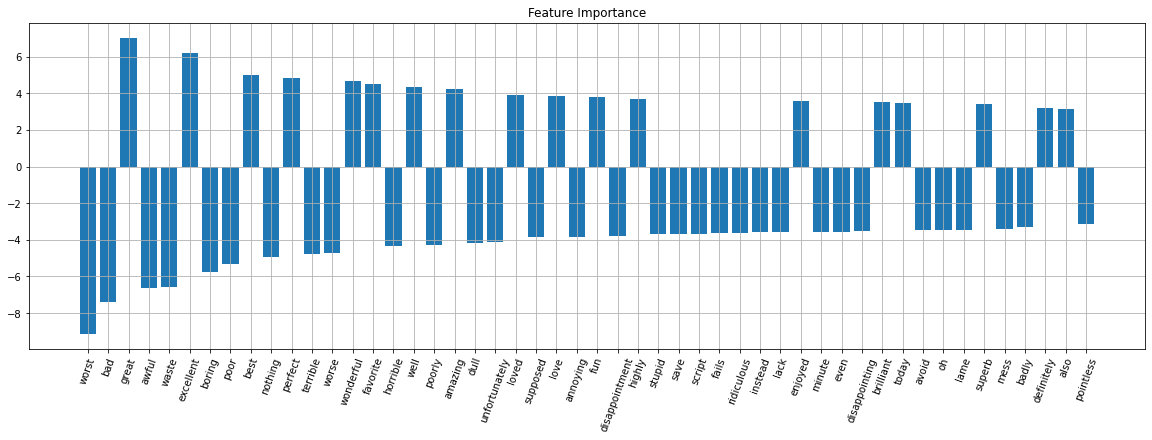

In [ ]:
from matplotlib import pyplot
from matplotlib.pyplot import figure
figure(figsize=(20, 6))
features = [x[0] for x in features_and_importance[0:50]]
importance = [x[1] for x in features_and_importance[0:50]]
pyplot.bar(range(50), importance)
pyplot.xticks(ticks=range(50), labels=features, rotation = 70)
pyplot.title("Feature Importance")
pyplot.grid()
pyplot.show()

## Choose "N" for N-gram

We change the model to use different numbers of "N" to check the performance gap between training and testing, and then use the gap to determine if there is any overfitting.

In [ ]:
def N_gram_TFIDF(n_in_Ngram, x_train, x_test, y_train, y_test):
    pipe = Pipeline([('vect', CountVectorizer(ngram_range=(n_in_Ngram, n_in_Ngram))),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])
    model = pipe.fit(x_train, y_train)
    train_prediction = model.predict(x_train)
    train_accuracy = round(accuracy_score(y_train, train_prediction)*100,2)
    test_prediction = model.predict(x_test)
    test_accuracy = round(accuracy_score(y_test, test_prediction)*100,2)
    train_report = classification_report(train_prediction, y_train, output_dict=True, digits=4)
    test_report = classification_report(test_prediction, y_test, output_dict=True, digits=4)
    return train_report['weighted avg']['f1-score'], test_report['weighted avg']['f1-score']
   

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(train_DF["processed_content"], train_DF["label"], test_size=0.2, random_state=2020)
result = []
for i in range(1,4):
    result.append(N_gram_TFIDF(i, x_train,x_test,y_train,y_test ))
result

[(0.937009494071624, 0.8863793860115844),
 (0.9952499862125515, 0.8482901205799137),
 (0.9998499998481181, 0.7566611661299039)]

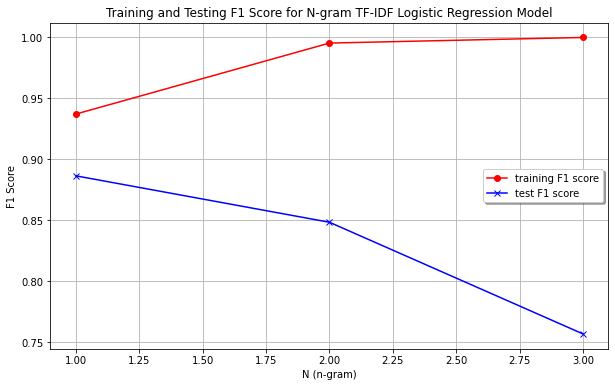

In [ ]:
figure(figsize=(10, 6))
plt.plot(range(1,4), [x[0] for x in result], 'r-o', range(1,4), [x[1] for x in result], 'b-x')
plt.legend(('training F1 score', 'test F1 score'), loc='center right', shadow=True)
plt.xlabel('N (n-gram)')
plt.ylabel('F1 Score')
plt.title('Training and Testing F1 Score for N-gram TF-IDF Logistic Regression Model')
plt.grid()
plt.show()

Based on the upper graph, due to the simplicity of the probablem, we see overfitting happends even with Uigram model. Therefore, we choose N=1.

## Cross Validation to Determine the Optimal Hyperparameters

From the upper graph, we see that even with the Uni-gram model,we still see some overfitting. Another way of mitigating overfitting is to add regularization, which is additional penalty to the error function.

In [ ]:
from sklearn.model_selection import StratifiedKFold 
import numpy as np
skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True) 
X = np.array(train_DF['processed_content'])
y = np.array(train_DF['label'])
train_dev_pair = []
for train_index, dev_index in skf.split(X, y):
    X_train, X_dev = X[train_index], X[dev_index]
    y_train, y_dev = y[train_index], y[dev_index]
    train_dev_pair.append(((X_train, y_train), (X_dev, y_dev)))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
def get_score(C, train_dev_pair):
    pipeline = Pipeline([
                ('vect', CountVectorizer(ngram_range=(1,1))),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(C=C))
                ])
    train_score = []
    dev_score = []
    for train, dev in train_dev_pair:
        model = pipeline.fit(train[0], train[1])
        train_prediction = model.predict(train[0])
        dev_prediction = model.predict(dev[0])
        train_report = classification_report(train_prediction, train[1], output_dict=True, digits=4)
        dev_report = classification_report(dev_prediction, dev[1], output_dict=True, digits=4)
        train_score.append(train_report['weighted avg']['f1-score']) 
        dev_score.append(dev_report['weighted avg']['f1-score']) 
    return sum(train_score)/len(train_score), sum(dev_score)/len(dev_score)

In [ ]:
result = []
for i in range(0, 10):
    C = min(i*0.3 + 0.1, 1)
    temp = get_score(C, train_dev_pair)
    result.append((C,temp))

In [ ]:
result[:4]

[(0.1, (0.880091556769619, 0.861386837646607)),
 (0.4, (0.9133894136078494, 0.8801262154821723)),
 (0.7, (0.9276986446509363, 0.885390198109711)),
 (0.9999999999999999, (0.9365953635556108, 0.8883055846534613))]

## Testing Performance

In [ ]:
pipe = Pipeline([('vect', CountVectorizer(ngram_range=(1, 1))),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(C=0.1))])
model = pipe.fit(train_DF['processed_content'], train_DF['label'])

In [ ]:
test_predictions = model.predict(test_DF['processed_content'])
print("accuracy: {}%".format(round(accuracy_score(test_predictions, test_DF['label'])*100,2)))
print(classification_report(test_predictions, test_DF['label'],digits=4))

accuracy: 85.84%
              precision    recall  f1-score   support

    negative     0.8378    0.8738    0.8554     11986
    positive     0.8790    0.8442    0.8613     13014

    accuracy                         0.8584     25000
   macro avg     0.8584    0.8590    0.8583     25000
weighted avg     0.8592    0.8584    0.8585     25000

